# Approximation Target Comparison for a Dense Neural Network

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

## Neural network integrator
This class is used to evaluate the performance of a neural network that approximates the next state directly, instead of one that approximates the correction and adds it to the previous state.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 2)]            0         
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable par

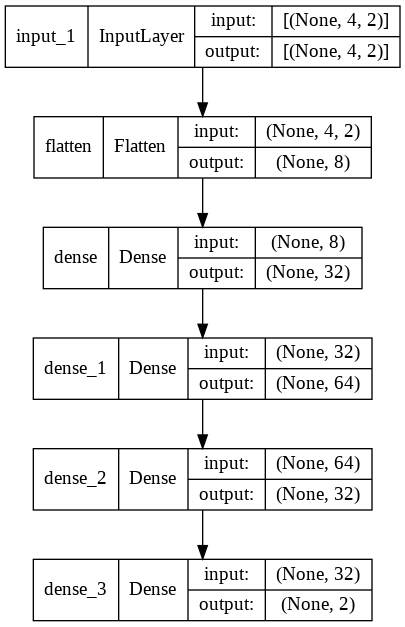

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for neural network integrator
nsteps = 4


harmonic_oscillator = HarmonicOscillator(mass,k_spring)
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_verlet)
nn_integrator = NNStateIntegrator(harmonic_oscillator,nsteps,dt)

# visualise the neural network model
nn_integrator.model.summary()
keras.utils.plot_model(nn_integrator.model, show_shapes=True)

In [ ]:
BATCH_SIZE=32
data_generator = DataGenerator(nn_integrator,verlet_integrator)
train_batches = data_generator.dataset.batch(BATCH_SIZE)

## Train neural network based integrator

In [ ]:
EPOCHS=100
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

Epoch 1/100
100/100 [==============================] - 5s 49ms/step - loss: 0.8149
Epoch 2/100
100/100 [==============================] - 5s 48ms/step - loss: 0.1941
Epoch 3/100
100/100 [==============================] - 5s 48ms/step - loss: 0.0528
Epoch 4/100
100/100 [==============================] - 5s 49ms/step - loss: 0.0459
Epoch 5/100
100/100 [==============================] - 5s 48ms/step - loss: 0.0392
Epoch 6/100
100/100 [==============================] - 5s 48ms/step - loss: 0.0293
Epoch 7/100
100/100 [==============================] - 5s 48ms/step - loss: 0.0239
Epoch 8/100
100/100 [==============================] - 5s 52ms/step - loss: 0.0192
Epoch 9/100
100/100 [==============================] - 5s 54ms/step - loss: 0.0143
Epoch 10/100
100/100 [==============================] - 5s 49ms/step - loss: 0.0131
Epoch 11/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0130
Epoch 12/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0110
E

## Visualise Loss function

dict_keys(['loss'])


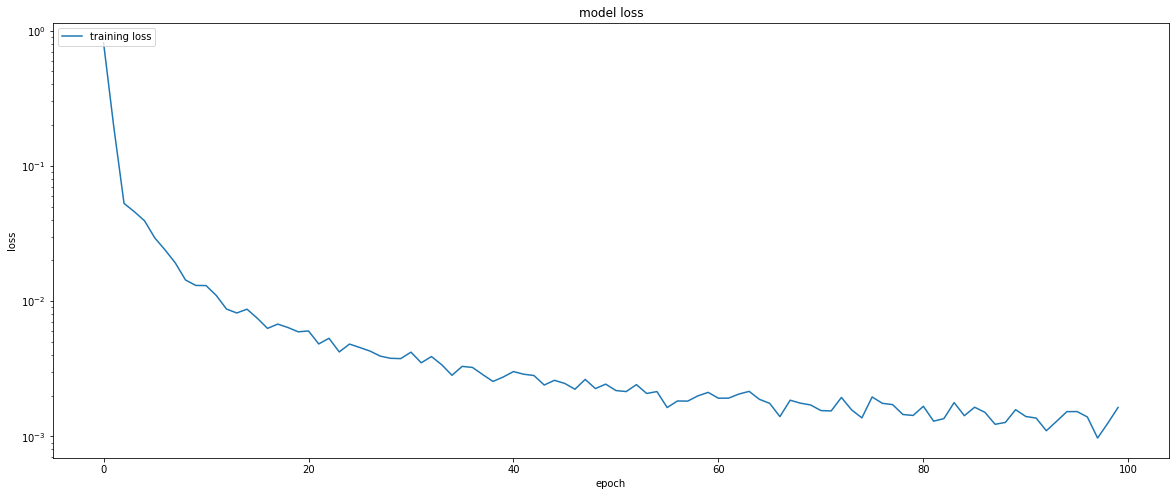

In [ ]:
print(result.history.keys())

plt.rcParams['figure.figsize'] = [20, 8]

# summarize history for loss
plt.plot(result.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories to $t=32$ generated by Verlet integrator and neural network based integrator

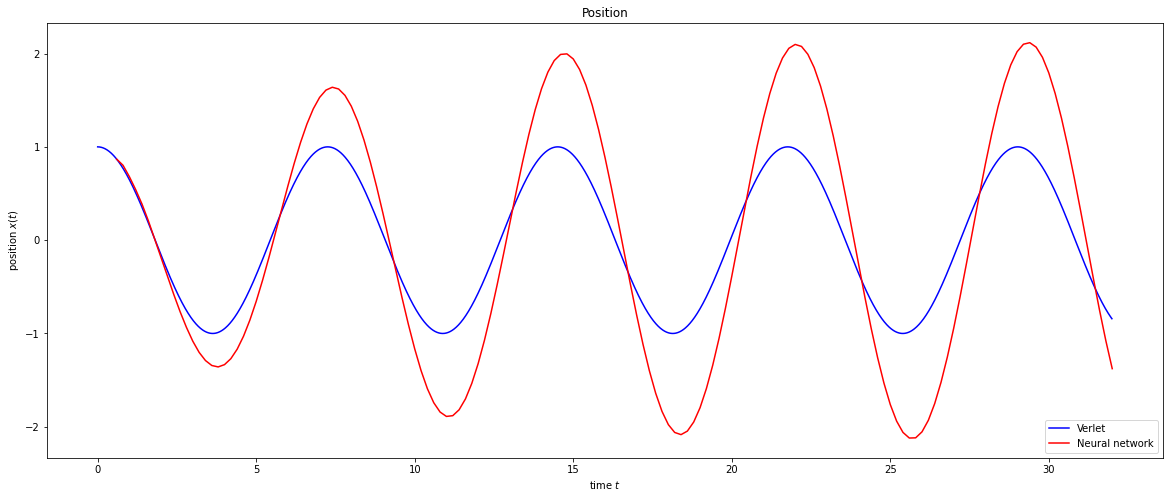

<Figure size 1440x576 with 0 Axes>

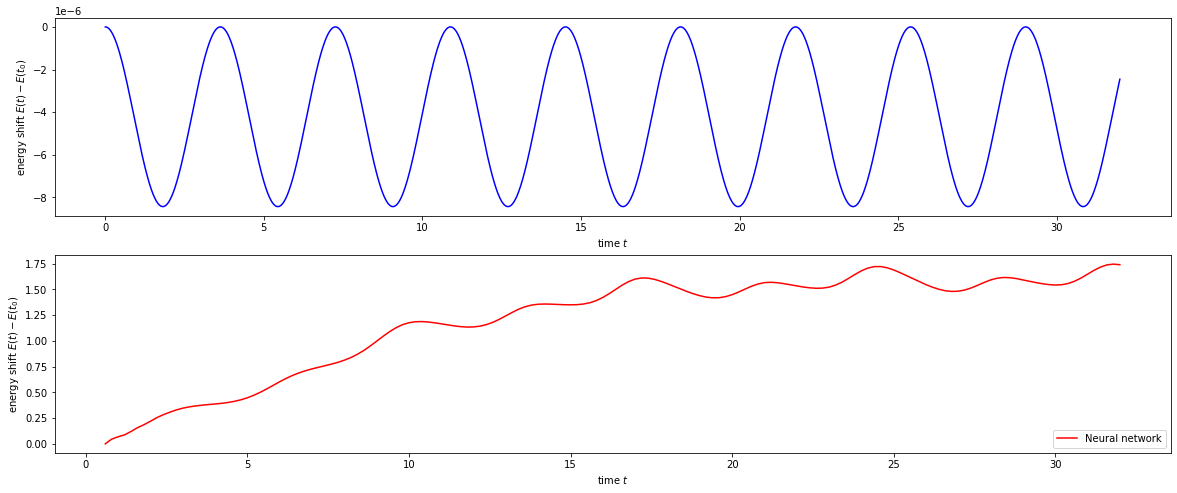

In [ ]:
# Final time
T_final = 32

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 1.0
v[0] = 0.0
verlet_integrator.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet = []
x_verlet = []
E_verlet = []
while t<T_final:
    t_verlet.append(t)
    E_verlet.append(verlet_integrator.energy())
    x_verlet.append(verlet_integrator.x[0])
    verlet_integrator.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
v_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
verlet_integrator.set_state(x,v)
for k in range(nn_integrator.nsteps):    
    x_initial[k,:] = verlet_integrator.x[:]
    v_initial[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))
nn_integrator.set_state(x_initial,v_initial)
t = (nn_integrator.nsteps-1)*nn_integrator.dt

# Timestepping loop
t_nn = []
x_nn = []
E_nn = []
while t<T_final:
    t_nn.append(t)
    x_nn.append(nn_integrator.x[0])
    E_nn.append(nn_integrator.energy())
    nn_integrator.integrate(1)
    t += dt

# Plot position as a function of time
plt.plot(t_verlet,x_verlet,label='Verlet',color='blue')
plt.plot(t_nn,x_nn,label='Neural network',color='red')
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position $x(t)$')
ax.set_title('Position')
plt.show()

plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)
fig, axs = plt.subplots(2,1)
axs[0].plot(t_verlet,E_verlet-E_verlet[0],label='Verlet',color='blue')
axs[1].plot(t_nn,E_nn-E_nn[0],label='Neural network',color='red')
plt.legend(loc='lower right')
for ax in axs:
    ax.set_xlabel('time $t$')
    ax.set_ylabel('energy shift $E(t)-E(t_0)$')
plt.show()